# Library

In [75]:
from queries import*
from utilities import*
import os
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [4]:
#!pip install google-cloud-bigquery
#!pip install xgboost
#!pip install shap

In [5]:
#!pip install xgboost
#!pip install shap

# Functions

In [6]:
def cleaning(name):
    dictio = {30:'3E1', 20:'2E1',10:'1E1'}
    if name in [30.0,20.0,10.0]:
        return dictio[int(name)]
    else :
        return name

In [7]:
def labeling_1(string, n_classes = 2, include_DR = False):
   

    
    if (n_classes == 2) and (include_DR == False):
        Patients_CR = ['1C1', '1Y1', '1N1', '1J1', '2Y1', '1O1', '1P1','3H1','3M1','3D1','1R1','2X1'] 
        progressors = ['2K1','1X1','2O1','2D1','3J1','3I1','2U1','2S1','2T1','2E1','2L1','2Q1','3J2','3E1']
        if str(string) in Patients_CR:
            return 1
        elif str(string) in progressors:
            return 0
        else :
            return -1

In [8]:
def class_1_weight_inspection(df,model='forest',crieterion ='gini', degree=8, min_weight = 1, max_weight=25):
    
    recall_scores = []

    data = df.copy()
    data = data.reset_index()
    data = data.drop(['index'], axis = 1)

    index_class_1 = list(data[data.label == 1].index)
    index_class_0 = list(data[data.label == 0].index)



    weights = range(min_weight,max_weight)

    weights_mean_training_error = []
    weights_mean_testing_error = []
    weights_mean_recall_error = []

    MODEL = model
    DEGREE = degree
    CRITERION = crieterion


    for weight in weights :
        print('Class 1 weight: ',weight)
        training_error =[]
        testing_error = []
        recall_scores =[]
        for iteration in range(3):
        
            print('iteration:', iteration)
        
            if MODEL == 'logistic':
                clf = SGDClassifier(loss = 'log', max_iter=1000 ,tol=1e-3, shuffle = True, learning_rate = 'adaptive',eta0=5, class_weight={0:1,1:weight},validation_fraction = 0.01)
            
            if MODEL == 'hinge':
                clf = SGDClassifier(loss = 'hinge', max_iter=1000, tol=1e-3, shuffle = True, learning_rate = 'adaptive',eta0=5, class_weight ={0:1,1:weight},validation_fraction = 0.01)
            
            if MODEL == 'rbf' :  
                clf = svm.SVC(C= 1, kernel ='rbf',class_weight={0:1,1:weight})
            
            if MODEL == 'polynomial':     
                clf = svm.SVC(C= 1, kernel ='poly', degree = DEGREE,class_weight={0:1,1:weight})
            
            if MODEL == 'forest'  :
                clf =  RandomForestClassifier(criterion=CRITERION,max_depth=10, random_state=0,class_weight={0:1,1:weight})

            
            
            train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
            train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 30)


            train_indicies = train_indicies_class_1 + train_indicies_class_0
            test_indicies = test_indicies_class_1 + test_indicies_class_0

            X_train =data.iloc[train_indicies,:].drop(['label','name'],axis=1)
            y_train = data.label.values[train_indicies]

            X_test =data.iloc[test_indicies,:].drop(['label','name'],axis=1)
            y_test = data.label.values[test_indicies]


            clf.fit(X_train,y_train)
            print('Training Error :')
            y_hat_train = clf.predict(X_train)
            print('True y_train :', y_train)
            print('Predicted y_train :', y_hat_train)
            recall_score_train = recall_score(y_train, y_hat_train)
            print(confusion_matrix(y_train, y_hat_train))
            print('Training recall class 1 : ', recall_score_train)
            training_error.append(clf.score(X_train,y_train))
    
    
            print('Training Error :')

            y_hat = clf.predict(X_test)
            print(y_hat)
            print(y_test)
            recall_score_testing = recall_score(y_test, y_hat)
            print('recall class 1 : ', recall_score_testing)
            print(confusion_matrix(y_test, y_hat))
            recall_scores.append(recall_score_testing)
            testing_error.append(clf.score(X_test,y_test))
        
        weights_mean_training_error.append(np.mean(training_error))  
        weights_mean_testing_error.append(np.mean(testing_error))
        weights_mean_recall_error.append(np.mean(recall_scores)) 
        
    return weights_mean_training_error,weights_mean_testing_error,weights_mean_recall_error

In [125]:
def fit_model(df, df_name,PLOT_DIRECTORY,MODEL = 'forest',N_FOLDS=3, N_CLASSES = 2,MINOR_CLASS_PENALTY =10,INCLUDE_DR=False, Boxplot=True):
    
    data = df.drop(['name'],axis=1)
    data = data.reset_index()
    data = data.drop(['index'], axis = 1)
    m = len(data.columns)

    index_class_1 = list(data[data.label == 1].index)
    index_class_0 = list(data[data.label == 0].index)
    index_class_DR = list(data[data.label == -1].index)

    iterations = range(N_FOLDS)
    training_acc =[]
    testing_acc =[]
    recall_acc =[]
    precision_acc = []
    recall_0_acc = []
    precision_0_acc = []
    f1_score_acc = []

    for iteration in iterations:
    
        if MODEL == 'logistic':
            clf = SGDClassifier(loss = 'log', max_iter=1000, tol=1e-3, shuffle = True, learning_rate = 'adaptive',eta0=5, class_weight ={0:1,1:MINOR_CLASS_PENALTY},validation_fraction = 0.01)
            
        if MODEL == 'hinge':
            clf = SGDClassifier(loss = 'hinge', max_iter=1000, tol=1e-3, shuffle = True, learning_rate = 'adaptive',eta0=5, class_weight ={0:1,1:MINOR_CLASS_PENALTY},validation_fraction = 0.01)
            
        if MODEL == 'rbf' :  
            clf = svm.SVC(C= 1, kernel ='rbf', class_weight={0:1,1:MINOR_CLASS_PENALTY})
            
        if MODEL == 'poly':     
            clf = svm.SVC(C= 1, kernel ='poly', degree=4, class_weight={0:1,1:MINOR_CLASS_PENALTY})
    
        if MODEL == 'forest'  :
            clf =  RandomForestClassifier(criterion='entropy',max_depth=20, random_state=0,class_weight={0:1,1:MINOR_CLASS_PENALTY})    
        
    
        print('iteration:', iteration)
    
        if N_CLASSES == 3 :
        
            clf = OneVsRestClassifier(clf)
            train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
            train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 20)
            train_indicies_class_DR , test_indicies_class_DR =  shuffle_and_pick(index_class_DR, 10)
            train_indicies = train_indicies_class_1 + train_indicies_class_0 + train_indicies_class_DR
            test_indicies = test_indicies_class_1 + test_indicies_class_0 + test_indicies_class_DR
        
        if (N_CLASSES == 2) and(INCLUDE_DR == False) :
        
            train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
            train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)
            train_indicies = train_indicies_class_1 + train_indicies_class_0
            test_indicies = test_indicies_class_1 + test_indicies_class_0 
        
        if (N_CLASSES == 2) and(INCLUDE_DR == True) :
        
            train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 17)
            train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 20)
            train_indicies = train_indicies_class_1 + train_indicies_class_0
            test_indicies = test_indicies_class_1 + test_indicies_class_0         
        

        X_train =data.iloc[train_indicies,:].drop(['label'],axis=1)
        y_train = data.label.values[train_indicies]

        X_test =data.iloc[test_indicies,:].drop(['label'], axis=1)

        y_test = data.label.values[test_indicies]


        clf.fit(X_train,y_train)
        print('Training Error :')
        y_hat_train = clf.predict(X_train)
        print('True y_train :', y_train)
        print('Predicted y_train :', y_hat_train)
        training_acc.append(clf.score(X_train,y_train))
        print(confusion_matrix(y_train, y_hat_train))
    
    
        print('Testing Error :')

        y_hat = clf.predict(X_test)
        testing_acc.append(clf.score(X_test,y_test))
        recall_acc.append(recall_score(y_test, y_hat))
        precision_acc.append(precision_score(y_test, y_hat))
        recall_0_acc.append(recall_score(y_test, y_hat ,pos_label=0))
        precision_0_acc.append(precision_score(y_test, y_hat,pos_label=0))
        f1_score_acc.append(f1_score(y_test, y_hat))
        print(y_hat)
        print(y_test)
        print(confusion_matrix(y_test, y_hat))
    
    
    if Boxplot == False :
        
        plt.figure(figsize=(15,7))

        plt.plot(iterations,training_acc, label = 'Training accuracy')
        plt.plot(iterations,testing_acc, label = 'Testing accuracy')
        plt.plot(iterations,recall_acc, label = 'recall class 1')
        plt.plot(iterations,precision_acc, label = 'precision class 1 ')

        plt.xlabel('Folds')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.savefig(PLOT_DIRECTORY + df_name +'_'+ MODEL+'.png') 
        
    else:
        
        metrics = pd.DataFrame({},columns =['train accuracy', 'test accuracy', 'recall', 'precision'])
        metrics['train accuracy'] = training_acc
        metrics['test accuracy'] = testing_acc
        
        metrics['recall'] = recall_acc
        metrics['precision'] = precision_acc
        
        metrics['precision_0'] = precision_0_acc
        metrics['recall_0'] = recall_0_acc
        
        metrics['f1'] = f1_score_acc

        
        metrics.to_csv('./data/output/metrics/'+df_name+'_'+MODEL+'.csv' )
        plt.figure(figsize=(15,7))
        sns.boxplot(data=metrics)
        plt.xlabel('METRICS')
        plt.ylabel('VALUES')
        plt.grid()
        plt.title( 'Metrics Boxplots : '+ df_name +' '+ MODEL)
        plt.savefig(PLOT_DIRECTORY + 'BOXPLOTS :'+df_name +'_'+ MODEL+'.png') 
        

iteration: 0
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0
 1 0 0 0 1 1 1]
[[15 19]
 [ 6  4]]
Testing Error :
[1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[ 5 10]
 [ 2  2]]
iteration: 1
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 1 0 0 1]
[[24 10]
 [ 6  4]]
Testing Error :
[0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[11  4]
 [ 4  0]]
iteration: 2
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0
 1 1 0 

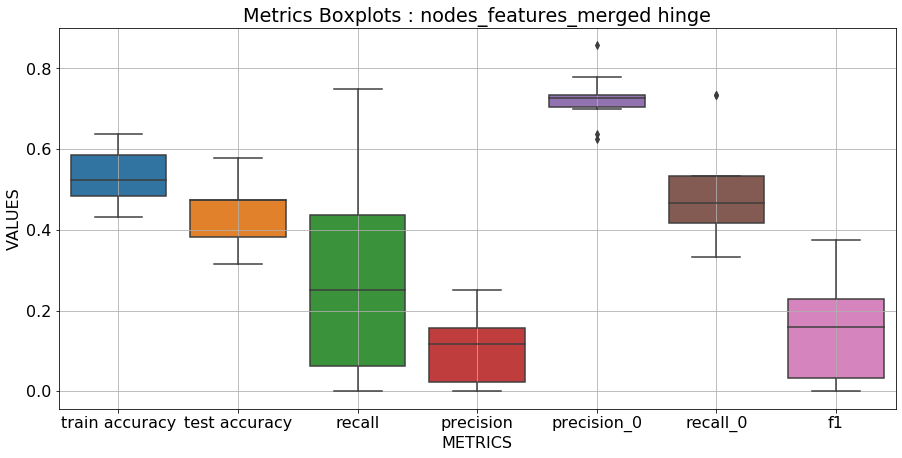

In [138]:
fit_model(nodes_features_merged,'nodes_features_merged',PLOT_DIRECTORY=PLOT_DIRECTORY,MODEL='hinge',N_FOLDS=10, N_CLASSES = 2,MINOR_CLASS_PENALTY =2.7,INCLUDE_DR=False, Boxplot=True)


# Parameters

In [10]:
PLOT_DIRECTORY = './plots/ANALYSIS/'
REMOVE_DR = False
INCLUDE_DR = False
N_CLASSES = 2
plt.rcParams['font.size'] = '16'

# Reading data

## Nodes features and Laplace quadtatic forms

In [11]:
directory = str(pathlib.Path().absolute()) + '/data/output/'
output_directory = os.listdir(directory)
nodes_features = pd.DataFrame({})
laplace_quadratics_features = pd.DataFrame({})

for folder in output_directory[:]:
    if folder.startswith('DEEPMEL'):
        
        nodes_stats = pd.read_csv(directory + folder +'/'+ 'nodes_stats.csv') 
        laplace_quadratics = pd.read_csv(directory + folder +'/'+ 'laplace_quadratic_form_high_level_graph.csv')
        
        nodes_features = pd.concat([nodes_features,nodes_stats])
        laplace_quadratics_features = pd.concat([laplace_quadratics_features,laplace_quadratics])
        
        


## Region cells density

In [12]:
region_nodes_counts = pd.read_csv('./data/input/region_phneo_count.csv')

## Clustering coefficients statistics per phenotype

In [13]:
clus_coef_df = pd.read_csv('./data/output/clustering_coefficients_statistics.csv')

### Dropping columns

In [14]:
columns_to_drop_from_laplace = ['cell_x_position','cell_y_position','NK','T_density','B_density','dendtritic_density','MISSING-DP1','MISSING-DP2','macrophages_density','NK_tumor_density','NK_density','NK_degree','missing_degree','MISSING_degree','MISSING-B', 'MISSING-MISSING','T-MISSING','macrophages-MISSING','stroma-MISSING','tumor-MISSING','MISSING','dendtritic-MISSING']
columns_to_drop_from_nodes = ['NK_in','MISSING','MISSING-B','MISSING-DP1','MISSING-DP2','MISSING-MISSING','T-MISSING','stroma-MISSING','macrophages-MISSING','missing_degree','dendtritic-MISSING','tumor-MISSING','MISSING_degree']

In [15]:
laplace_quadratics_features = laplace_quadratics_features.drop(columns_to_drop_from_laplace,axis=1)
nodes_features = nodes_features.drop(columns_to_drop_from_nodes , axis=1)

# Adding labels

In [16]:
nodes_features['name'] = nodes_features.name.apply(lambda x: cleaning(x))
nodes_features['label'] = nodes_features.name.apply(lambda x: labeling(x,N_CLASSES,INCLUDE_DR))

laplace_quadratics_features['name']  =  nodes_features.name.values
#laplace_quadratics_features= laplace_quadratics_features[list(laplace_quadratics_features.columns[47:48]) + list(laplace_quadratics_features.columns[:47]) ]
laplace_quadratics_features['label'] =  laplace_quadratics_features.name.apply(lambda x: labeling(x,N_CLASSES,INCLUDE_DR))

region_nodes_counts['label'] = region_nodes_counts.name.apply(lambda x: labeling(x,N_CLASSES,INCLUDE_DR))
clus_coef_df['label'] = clus_coef_df.name.apply(lambda x: labeling(x,N_CLASSES,INCLUDE_DR))

In [17]:
nodes_features = nodes_features.fillna(0)
laplace_quadratics_features = laplace_quadratics_features.fillna(0)

In [18]:
nodes_features = nodes_features[nodes_features.label!=-1]
laplace_quadratics_features = laplace_quadratics_features[laplace_quadratics_features.label!=-1]
region_nodes_counts = region_nodes_counts[region_nodes_counts.label!=-1]
clus_coef_df = clus_coef_df[clus_coef_df.label!=-1]

In [19]:
nodes_features.label.value_counts()

0    49
1    14
Name: label, dtype: int64

In [20]:
laplace_quadratics_features = laplace_quadratics_features.rename(columns = {'size_y' : 'component_size'})
laplace_quadratics_features = laplace_quadratics_features.drop(['size_x','DP2T_tumor_density'], axis = 1)

## Drop duplicates in names

In [21]:
laplace_quadratics_features = laplace_quadratics_features.drop_duplicates(['name'])
clus_coef_df = clus_coef_df.drop_duplicates(['name'])
region_nodes_counts = region_nodes_counts.drop_duplicates(['name'])
nodes_features = nodes_features.drop_duplicates(['name'])

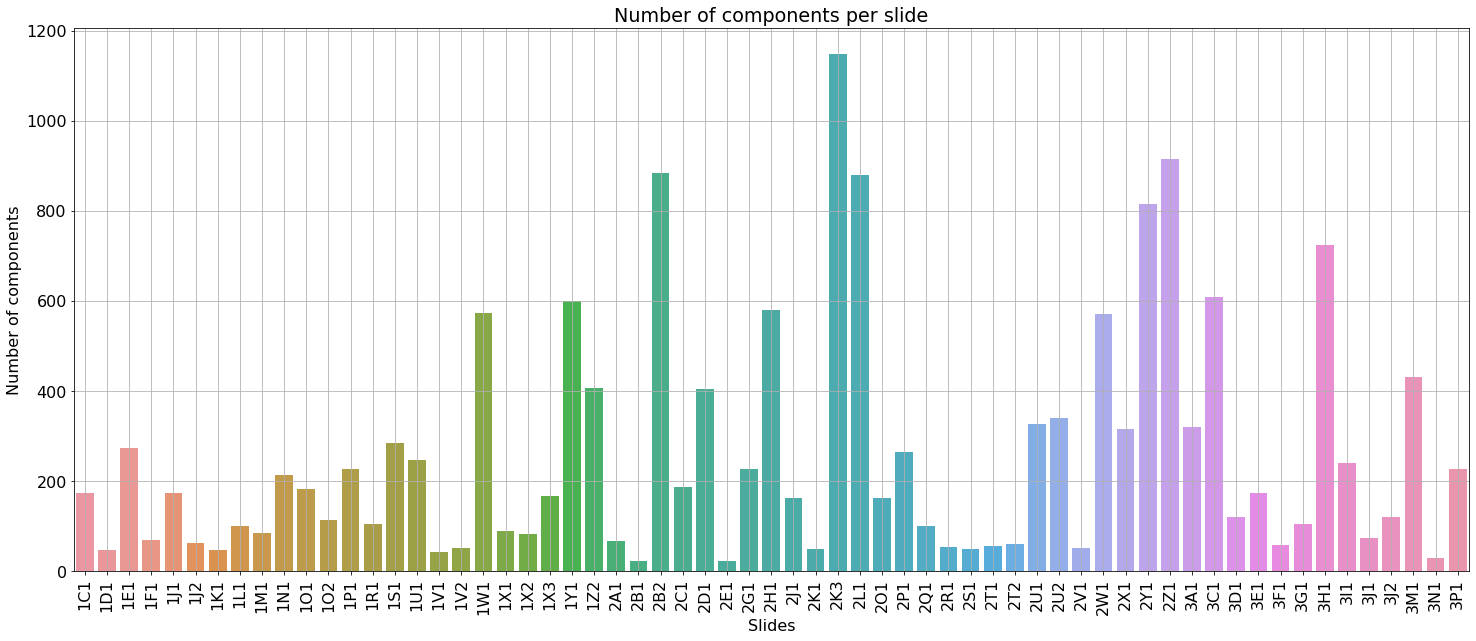

In [22]:
columns_to_keep = ['name', 'n_final_components']
data = nodes_features[columns_to_keep]
plt.subplots(figsize=(25, 10))

sns.barplot(x="name", y='n_final_components', data=data)
plt.xticks(rotation=90) 
plt.title('Number of components per slide')
plt.grid()
plt.xlabel('Slides')
plt.ylabel('Number of components')
plt.savefig(PLOT_DIRECTORY +'n_final_components.png')

## Defining columns subsets

### Nodes features columns

In [23]:
cell_density_columns = ['name', 'B', 'NK', 'T', 'macrophages','dendtritic', 'stroma', 'tumor','label','DP1','DP2']


edge_count_columns = ['name','B-B', 'T-B', 'T-T', 'macrophages-B','DP1-B', 'DP1-DP1','T-DP1',
       'macrophages-T', 'macrophages-macrophages', 'stroma-B', 'stroma-T','dendtritic-DP1',
       'stroma-macrophages', 'stroma-stroma', 'tumor-B', 'tumor-T','stroma-DP1','tumor-DP1',
       'tumor-macrophages', 'tumor-stroma', 'tumor-tumor','dendtritic-B', 'dendtritic-T',
       'dendtritic-dendtritic', 'macrophages-dendtritic', 'stroma-dendtritic','DP2-B',
       'DP2-DP1', 'DP2-DP2', 'T-DP2', 'dendtritic-DP2',
       'macrophages-DP2', 'stroma-DP2', 'tumor-DP2',
       'tumor-dendtritic','label']

tils_infiltration_columns = ['name','T_out', 'B_out','NK_out', 'T_in', 'B_in','label']

graph_based_columns = ['name','AUC_total_graph','whole_graph_transitivity', 'border_graph_sparsity',
       'border_graph_transitivity', 'n_initial_components',
       'size_largest_component', 'n_final_components',
       'median_clustering_coefficient','nbr_edges','label']

degrees_columns = ['name','B_degree', 'T_degree', 'macrophages_degree', 'DP1_degree','DP2_degree',
       'stroma_degree', 'stroma_pheno_degree', 'total_degree', 'tumor_degree',
       'tumor_pheno_degree','dendtritic_degree','label']


tumor_tissue_density_columns = ['name','tumor_region_B', 'tumor_region_DP1','tumor_region_dendtritic',
       'tumor_region_DP2',  'tumor_region_NK',
       'tumor_region_T', 'tumor_region_macrophages', 'tumor_region_stroma',
       'tumor_region_tumor','label']


stroma_tissue_density_columns = ['name','stroma_region_B', 'stroma_region_DP1',
       'stroma_region_DP2',  'stroma_region_NK','stroma_region_dendtritic',
       'stroma_region_T', 'stroma_region_macrophages', 'stroma_region_stroma',
       'stroma_region_tumor','label']


border_tissue_density_columns = ['name','border_region_dendtritic', 
        'border_region_B', 'border_region_DP1',
       'border_region_DP2', 'border_region_T',
       'border_region_macrophages', 'border_region_stroma',
       'border_region_tumor','label']

clustering_coef = ['name','B_mean', 'DP1_mean', 'DP2_mean', 'MISSING_mean', 'T_mean',
       'macrophages_mean', 'stroma_mean', 'tumor_mean', 'B_median',
       'DP1_median', 'DP2_median', 'MISSING_median', 'T_median',
       'macrophages_median', 'stroma_median', 'tumor_median', 'B_var',
       'DP1_var', 'DP2_var', 'MISSING_var', 'T_var', 'macrophages_var',
       'stroma_var', 'tumor_var',  'dendtritic_mean',
       'dendtritic_median', 'dendtritic_var', 'label']


nodes_columns = {'cell_density': cell_density_columns, 'edges_count': edge_count_columns, 'tils_infiltration':tils_infiltration_columns, 'graph_topology':graph_based_columns,
           'degrees':degrees_columns, 'tumor_tissue_density':tumor_tissue_density_columns, 'stroma_tissue_density':stroma_tissue_density_columns, 
           'border_tissue_density':border_tissue_density_columns, 'clustering_coef_stats':clustering_coef}




### Laplace nodes columns

In [24]:
edge_count = ['name', 'B-B', 'T-B', 'T-T', 'macrophages-B',
       'macrophages-T', 'macrophages-macrophages', 'stroma-B', 'stroma-T',
       'stroma-macrophages', 'stroma-stroma', 'tumor-B', 'tumor-T',
       'tumor-macrophages', 'tumor-stroma', 'tumor-tumor', 'dendtritic-B', 'dendtritic-T',
       'dendtritic-dendtritic', 'macrophages-dendtritic', 'stroma-dendtritic',
       'tumor-dendtritic' ,'label']

degrees = ['name','tumor_degree', 'stroma_degree', 'total_degree', 'tumor_pheno_degree',
       'stroma_pheno_degree', 'macrophages_degree', 'T_degree', 'B_degree','label']

cell_counts = ['name','B', 'T','macrophages', 'stroma', 'tumor','dendtritic','label']

tils_tumor_ratio = ['name', 'T_tumor_density', 'B_tumor_density','macrophages_tumor_density','dendtritic_tumor_density' ,'stroma_tumor_density','label']

graph_topology = ['name','clustering_coef', 'AUC_area','component_size','label']


laplace_columns = {'edge_count': edge_count, 'degree': degrees, 'cell_count':cell_counts, 'tils_tumor_ratio':tils_tumor_ratio,'graph_topology':graph_topology}

In [25]:
if REMOVE_DR == True :
    laplace_quadratics_features = laplace_quadratics_features[laplace_quadratics_features.label != -1]
    nodes_features = nodes_features[nodes_features.label != -1]
    region_nodes_counts = region_nodes_counts[region_nodes_counts.label!=-1]

# Analysis on nodes features 

## Correlation analysis

In [26]:
correlation_nodes = nodes_features.corr('pearson')
f, ax = plt.subplots(figsize=(7, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,73:],annot=True)

if (INCLUDE_DR == False) and (N_CLASSES == 2):
    plt.tight_layout()

    plt.savefig(PLOT_DIRECTORY + 'nodes_features_correlation_label.png')

if (INCLUDE_DR == True) and (N_CLASSES == 2):
    plt.tight_layout()

    plt.savefig(PLOT_DIRECTORY + '2_class_DR_nodes_features_correlation_label.png')
plt.close()

In [27]:
correlation_types = ['pearson','kendall','spearman']
correlation_type = correlation_types[2]
correlation_nodes = nodes_features.corr(correlation_type)
f, ax = plt.subplots(figsize=(7, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,73:],annot=True)
plt.tight_layout()
plt.savefig(PLOT_DIRECTORY + 'nodes_features_'+correlation_type+'_correlation_label.png')
plt.close()

In [28]:
correlation_nodes = nodes_features.corr()
f, ax = plt.subplots(figsize=(5, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,:],annot=False)
if (INCLUDE_DR == False) and (N_CLASSES == 2):
    plt.tight_layout()

    plt.savefig(PLOT_DIRECTORY + 'nodes_features_correlation.png')

if (INCLUDE_DR == True) and (N_CLASSES == 2):
    plt.tight_layout()

    plt.savefig(PLOT_DIRECTORY + '2_classes_DR_nodes_features_correlation.png', )

plt.close()

## Kendall correlation

In [29]:
label = nodes_features.label.values
nodes_columns_ = nodes_features.columns[1:]
kendall_corr ={}
for column in nodes_columns_:
    column_value = nodes_features[column].values
    kendall_corr[column] = scipy.stats.kendalltau(column_value, label).correlation

kendall_corr = pd.DataFrame(kendall_corr, index = [0])
kendall_corr = pd.melt(kendall_corr).set_index(['variable'])
f, ax = plt.subplots(figsize=(5, 20))
ax = sns.heatmap(kendall_corr,annot=True)


if (INCLUDE_DR == False) and (N_CLASSES == 2):
    plt.tight_layout()

    plt.savefig(PLOT_DIRECTORY + 'nodes_kendall_tau.png')


if (INCLUDE_DR == True) and (N_CLASSES == 2):
    plt.tight_layout()

    plt.savefig(PLOT_DIRECTORY + '2_classes_DR_nodes_kendall_tau.png')


plt.close()


## Spearman Tau 

In [30]:
label = nodes_features.label.values
nodes_columns_ = nodes_features.columns[1:]
spearmanr_corr ={}


for column in nodes_columns_:
    column_value = nodes_features[column].values
    spearmanr_corr[column] = scipy.stats.spearmanr(column_value, label).correlation

    
spearmanr_corr = pd.DataFrame(spearmanr_corr, index = [0])
spearmanr_corr = pd.melt(spearmanr_corr).set_index(['variable'])
f, ax = plt.subplots(figsize=(5, 20))
ax = sns.heatmap(spearmanr_corr,annot=True)

if (INCLUDE_DR == False) and (N_CLASSES == 2):
    plt.tight_layout()

    plt.savefig(PLOT_DIRECTORY + 'nodes_spearman_rho.png')


if (INCLUDE_DR == True) and (N_CLASSES == 2):
    plt.tight_layout()

    plt.savefig(PLOT_DIRECTORY + '2_classes_DR_nodes_spearman_rho.png')


plt.close()


In [31]:
label = nodes_features.label.values
nodes_columns_ = nodes_features.columns[1:]
kendall_corr ={}
for column in nodes_columns_:
    column_value = nodes_features[column].values
    kendall_corr[column] = scipy.stats.kendalltau(column_value, label).correlation

kendall_corr = pd.DataFrame(kendall_corr, index = [0])
kendall_corr = pd.melt(kendall_corr).set_index(['variable'])
f, ax = plt.subplots(figsize=(10, 20))
plt.tight_layout()

ax = sns.heatmap(kendall_corr,annot=True)
plt.close()

# Clustering 

## K-means clustering

In [32]:
N_CLUSTER = 2
X = nodes_features.iloc[:,1:53]
y = nodes_features.label.values
kmeans = KMeans(n_clusters=N_CLUSTER, random_state=0).fit(X)
predicted_label = kmeans.labels_

In [33]:
predicted_label

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
      dtype=int32)

In [34]:
y

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

In [35]:
distance.hamming(predicted_label, y)

0.6507936507936508

In [36]:
confusion_matrix(y,predicted_label)

array([[14, 35],
       [ 6,  8]])

## Hierarchical clustering

### Ward

In [37]:
clustering = AgglomerativeClustering(linkage = 'ward').fit(X)
hierarchical_label = clustering.labels_
hierarchical_label

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0])

In [38]:
distance.hamming(hierarchical_label, y)

0.5714285714285714

In [39]:
confusion_matrix(y,hierarchical_label)

array([[21, 28],
       [ 8,  6]])

### Complete

In [40]:
clustering = AgglomerativeClustering(linkage = 'complete').fit(X)
hierarchical_complete_label = clustering.labels_

In [41]:
hierarchical_complete_label = list(map(lambda x : 1 if(x==0)  else 0, hierarchical_complete_label))

In [42]:
confusion_matrix(y,hierarchical_complete_label)

array([[35, 14],
       [ 9,  5]])

# Principal component analysis 

In [43]:
pca = PCA(n_components=3)
label = nodes_features.label.values
features_scaled= nodes_features.drop(['name','label'],axis=1)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf['label'] = label

<Figure size 432x288 with 0 Axes>

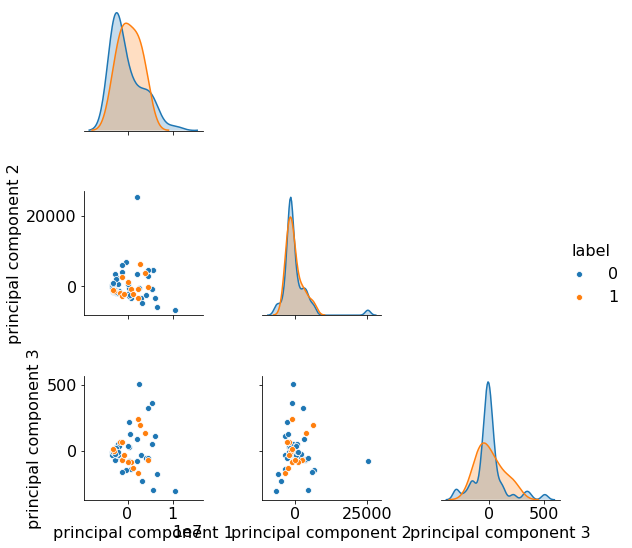

In [44]:
if (INCLUDE_DR == False) and (N_CLASSES == 2):
    plt.tight_layout()

    sns.pairplot(principalDf, hue='label', corner =True).savefig(PLOT_DIRECTORY+'nodes_features_PCA.png')



if (INCLUDE_DR == True) and (N_CLASSES == 2):
    sns.pairplot(principalDf, hue='label', corner =True).savefig(PLOT_DIRECTORY+'2_classes_DR_nodes_features_PCA.png')



In [45]:
pca.explained_variance_ratio_

array([9.99998265e-01, 1.73267242e-06, 1.76624595e-09])

## PCA per set of features

In [46]:
densities = region_nodes_counts.drop(['label'],axis =1)
coef = clus_coef_df.drop(['label'],axis =1)

nodes_features_merged = nodes_features.merge(densities, on ='name', how = 'inner')
nodes_features_merged = nodes_features_merged.merge(coef,on ='name', how = 'inner')

In [47]:
list_columns_sets = list(nodes_columns.keys())
principal_component_explained_df = pd.DataFrame({})

for column_set in list_columns_sets:
     
    columns_values = nodes_columns[column_set]
    n = len(columns_values)
    restricted_data = nodes_features_merged[columns_values]
    X = restricted_data.drop(['name','label'], axis=1)
    label = restricted_data.label.values
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
    principalDf['label'] = label
    explained_variance_ratio = pca.explained_variance_ratio_
    print(explained_variance_ratio)
    df = pd.DataFrame({'name':column_set,'pc1':explained_variance_ratio[0],'pc2':explained_variance_ratio[1],'pc3':explained_variance_ratio[2]}, index =[0])
    principal_component_explained_df = pd.concat([principal_component_explained_df,df])
    plt.tight_layout()

    sns.pairplot(principalDf, hue='label', corner =True)
    
    plt.savefig(PLOT_DIRECTORY+ column_set+'_PCA.png')
    plt.close()
    

[0.63667994 0.33360853 0.01447822]
[0.62214255 0.30118807 0.03556194]
[0.74060327 0.16065591 0.06382135]
[9.99998265e-01 1.73267208e-06 1.76584007e-09]
[0.57730223 0.24268079 0.13053479]
[0.95916381 0.02528805 0.01060126]
[0.5875361  0.39594065 0.01039441]
[0.48855302 0.3660667  0.12581543]
[0.5997775  0.28694053 0.03237072]


<Figure size 432x288 with 0 Axes>

In [48]:
print(principal_component_explained_df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                  name &       pc1 &       pc2 &           pc3 \\
\midrule
          cell\_density &  0.636680 &  0.333609 &  1.447822e-02 \\
           edges\_count &  0.622143 &  0.301188 &  3.556194e-02 \\
     tils\_infiltration &  0.740603 &  0.160656 &  6.382135e-02 \\
        graph\_topology &  0.999998 &  0.000002 &  1.765840e-09 \\
               degrees &  0.577302 &  0.242681 &  1.305348e-01 \\
  tumor\_tissue\_density &  0.959164 &  0.025288 &  1.060126e-02 \\
 stroma\_tissue\_density &  0.587536 &  0.395941 &  1.039441e-02 \\
 border\_tissue\_density &  0.488553 &  0.366067 &  1.258154e-01 \\
 clustering\_coef\_stats &  0.599777 &  0.286941 &  3.237072e-02 \\
\bottomrule
\end{tabular}



# PCA all features

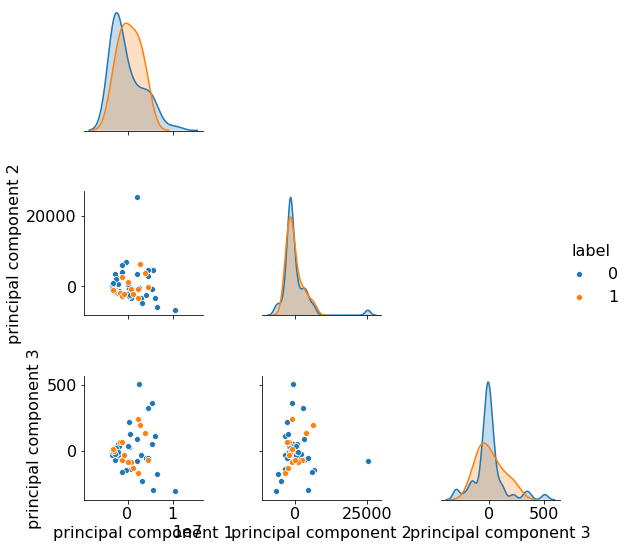

In [49]:
pca = PCA(n_components=3)
label = nodes_features_merged.label.values
features_scaled= nodes_features_merged.drop(['name','label'],axis=1)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf['label'] = label
sns.pairplot(principalDf, hue='label', corner =True).savefig(PLOT_DIRECTORY+'ALL_nodes_features_PCA.png')

In [50]:
pca.explained_variance_ratio_

array([9.99998265e-01, 1.73267242e-06, 1.76624726e-09])

# Canonical Correlation analysis

In [51]:
nodes_features.columns[:]

Index(['name', 'B', 'DP1', 'NK', 'T', 'dendtritic', 'macrophages', 'stroma',
       'tumor', 'nbr_edges', 'B-B', 'DP1-B', 'DP1-DP1', 'T-B', 'T-DP1', 'T-T',
       'dendtritic-B', 'dendtritic-DP1', 'dendtritic-T',
       'dendtritic-dendtritic', 'macrophages-B', 'macrophages-T',
       'macrophages-dendtritic', 'macrophages-macrophages', 'stroma-B',
       'stroma-DP1', 'stroma-T', 'stroma-dendtritic', 'stroma-macrophages',
       'stroma-stroma', 'tumor-B', 'tumor-DP1', 'tumor-T', 'tumor-dendtritic',
       'tumor-macrophages', 'tumor-stroma', 'tumor-tumor', 'AUC_total_graph',
       'T_out', 'B_out', 'NK_out', 'T_in', 'B_in', 'B_degree', 'DP1_degree',
       'T_degree', 'dendtritic_degree', 'macrophages_degree', 'stroma_degree',
       'stroma_pheno_degree', 'total_degree', 'tumor_degree',
       'tumor_pheno_degree', 'whole_graph_sparsity',
       'whole_graph_transitivity', 'border_graph_sparsity',
       'border_graph_transitivity', 'n_initial_components',
       'size_largest_comp

In [52]:
X = nodes_features.drop(['name','label'],axis=1)
Y = nodes_features.label.values

In [53]:
ca = CCA()
ca.fit(X, Y)
X_c, Y_c = ca.transform(X, Y)

print(X_c.shape)
print(Y_c.shape)

(63, 2)
(63,)


Y residual constant at iteration 1


In [54]:
np.corrcoef(X_c[:,0], Y_c[:])

array([[1., 1.],
       [1., 1.]])

In [55]:
X_c[:,0]

array([ 0.0577348 , -0.01649566, -0.01649566, -0.01649566,  0.0577348 ,
        0.0577348 , -0.01649566, -0.01649566, -0.01649566,  0.0577348 ,
        0.0577348 ,  0.0577348 ,  0.0577348 ,  0.0577348 , -0.01649566,
       -0.01649566, -0.01649566, -0.01649566, -0.01649566, -0.01649566,
       -0.01649566, -0.01649566,  0.0577348 , -0.01649566,  0.0577348 ,
       -0.01649566, -0.01649566, -0.01649566, -0.01649566, -0.01649566,
       -0.01649566, -0.01649566, -0.01649566, -0.01649566, -0.01649566,
       -0.01649566, -0.01649566, -0.01649566, -0.01649566, -0.01649566,
       -0.01649566, -0.01649566, -0.01649566, -0.01649566, -0.01649566,
       -0.01649566, -0.01649566, -0.01649566,  0.0577348 , -0.01649566,
       -0.01649566, -0.01649566,  0.0577348 , -0.01649566, -0.01649566,
       -0.01649566,  0.0577348 , -0.01649566, -0.01649566, -0.01649566,
        0.0577348 , -0.01649566, -0.01649566])

## How much does each variable add to the canonical correlation

Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant 

-0.11333069642190864


Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1


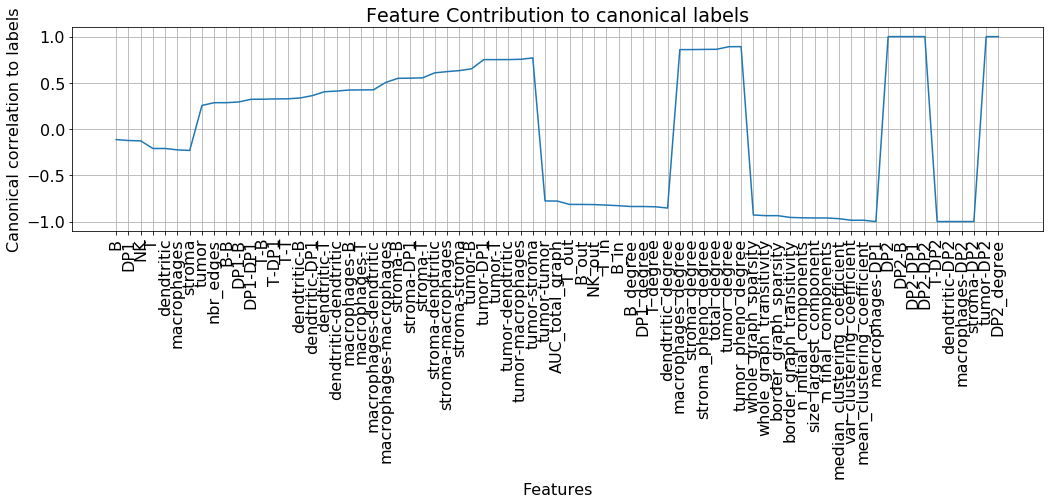

In [56]:
X = nodes_features.drop(['name','label'],axis=1)
Y = nodes_features.label.values
X_columns = nodes_features.drop(['name','label'],axis=1).columns
set_columns = [X_columns[0]]
initial_coor = nodes_features[[X_columns[0],'label']].corr().iloc[0,1]
print(initial_coor)
corr_contribution = [initial_coor]
for column in X_columns[1:] :
    set_columns.append(column)
    X_restricted = X[set_columns]
    ca = CCA()
    ca.fit(X_restricted, Y)
    X_c, Y_c = ca.transform(X_restricted, Y)
    
    corr_contribution.append(np.corrcoef(X_c[:,0], Y_c[:])[0,1])

    
    
    
plt.figure(figsize=(15,7))

plt.plot(X_columns,corr_contribution  )


plt.xlabel('Features')
plt.xticks(rotation=90) 
plt.ylabel('Canonical correlation to labels')
plt.grid()
plt.tight_layout()

plt.title( 'Feature Contribution to canonical labels' )
plt.savefig(PLOT_DIRECTORY + 'Feature_Contribution_to_canonical_labels.png')    

# Checking separability

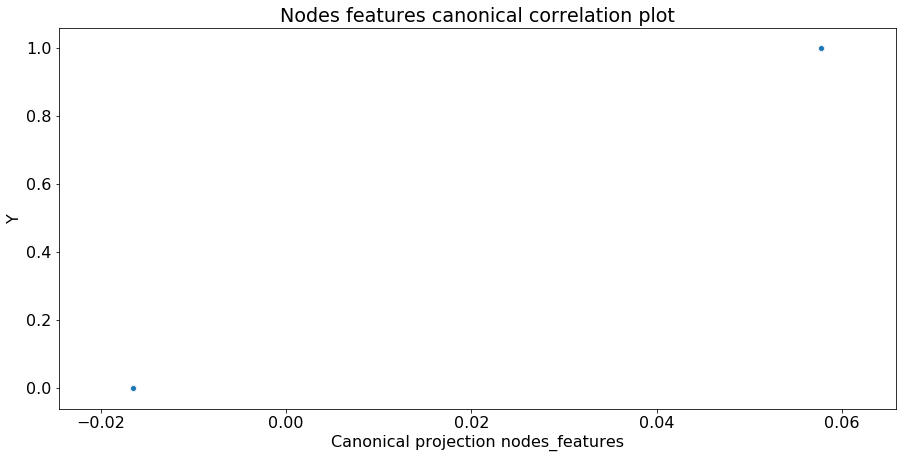

In [57]:
X_c_1 = [x[0] for x in X_c]
plt.figure(figsize=(15,7))
sns.scatterplot(X_c_1,Y)
plt.xlabel('Canonical projection nodes_features')
plt.ylabel('Y')
plt.title('Nodes features canonical correlation plot')
plt.savefig(PLOT_DIRECTORY + 'canonical_correlation_all_nodes_features.png')

### Fitting a 1D classifier

In [58]:
X_c_1 = np.array(X_c_1).reshape(-1,1)

In [59]:
clf = svm.SVC(kernel ='rbf' , class_weight='balanced')

clf.fit(X_c_1,Y)
y_pred = clf.predict(X_c_1)
confusion_matrix(Y,y_pred)

array([[49,  0],
       [ 0, 14]])

### Checking CCA independently using set of columns
#### Merging nodes_features to region cells densities

In [60]:
densities = region_nodes_counts.drop(['label'],axis =1)
coef = clus_coef_df.drop(['label'],axis =1)

nodes_features_merged = nodes_features.merge(densities, on ='name', how = 'inner')
nodes_features_merged = nodes_features_merged.merge(coef,on ='name', how = 'inner')

In [61]:
list_columns_sets = list(nodes_columns.keys())
canonical_correlation = []

for column_set in list_columns_sets:
     
    columns_values = nodes_columns[column_set]
    n = len(columns_values)
    restricted_data = nodes_features_merged[columns_values]
    X = restricted_data.drop(['name','label'], axis=1)
    Y = restricted_data.label.values
    ca = CCA()
    ca.fit(X, Y)
    X_c, Y_c = ca.transform(X, Y)
    
    cca = np.corrcoef(X_c[:, 0], Y_c[:, ])[0,1]
    canonical_correlation.append(cca)
    print(cca)


0.35890276254700665
0.7935605731378652
0.2745568674878158
0.34464377175781596
0.3716205362932828
-0.26714860234118376
0.5087794512770921
0.3841163151060809
-0.697948423205473


Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1


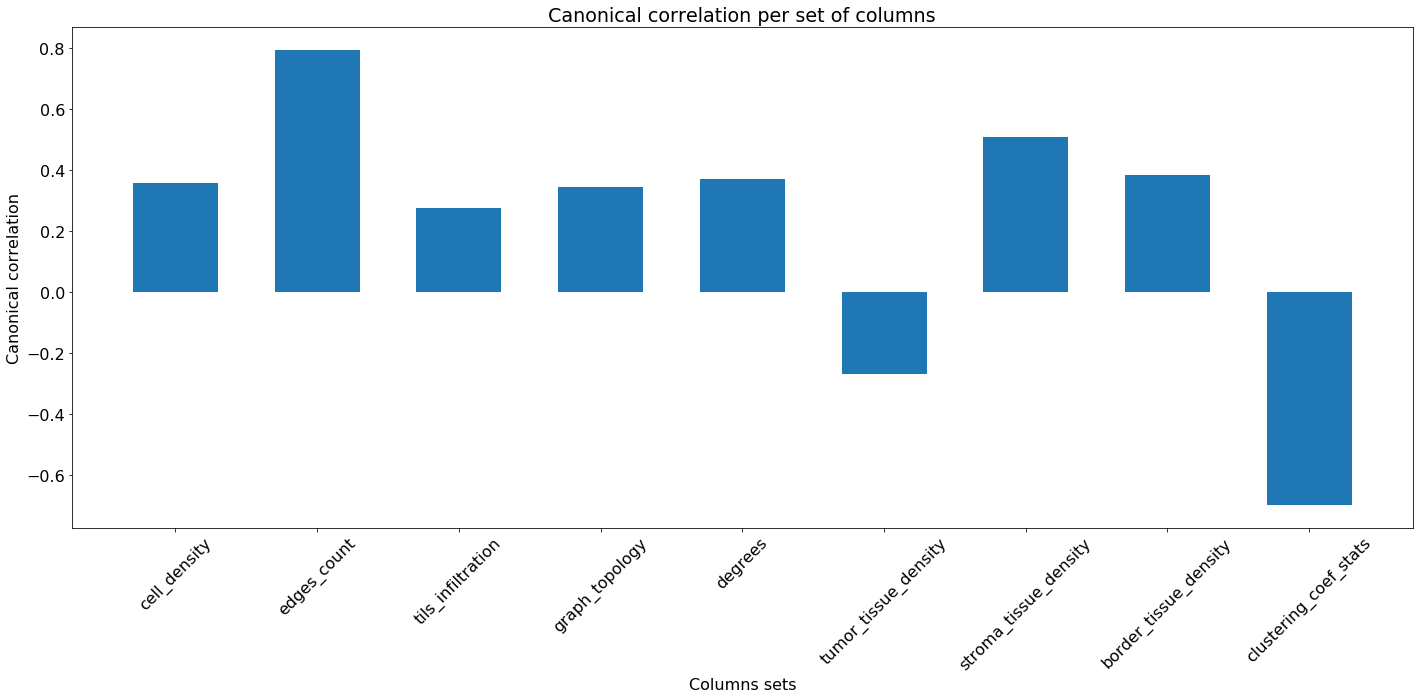

In [62]:
plt.figure(figsize=(20,10))

plt.bar(list_columns_sets, canonical_correlation, width = 0.6)

plt.xlabel('Columns sets')
plt.xticks(rotation=45)
plt.ylabel('Canonical correlation')
plt.title('Canonical correlation per set of columns')
plt.tight_layout()

plt.savefig(PLOT_DIRECTORY + 'Canonical correlation per set of columns.png')

## Projection CCA and separability

Y residual constant at iteration 1


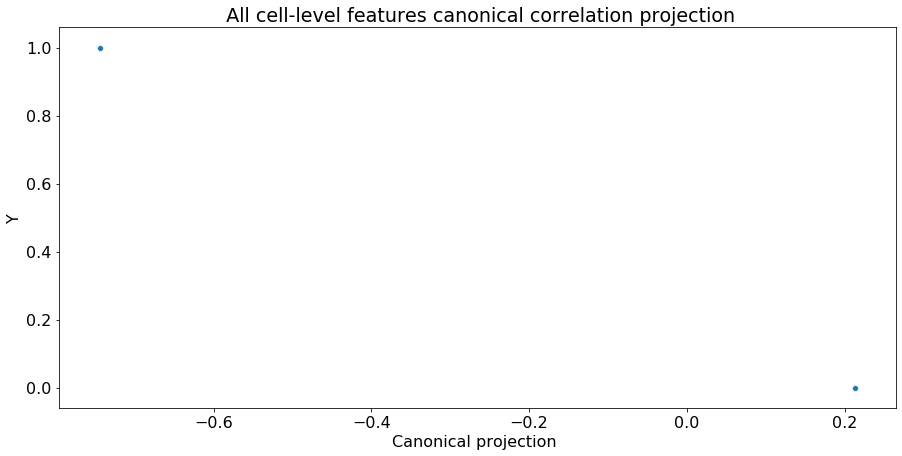

In [63]:
#feature_set = 'edges_count'
#columns = nodes_columns[feature_set]
X = nodes_features_merged.drop(['name','label'],axis=1)
Y = nodes_features_merged.label.values

ca = CCA()
ca.fit(X, Y)
X_c, Y_c = ca.transform(X, Y)


X_c_1 = [x[0] for x in X_c]
plt.figure(figsize=(15,7))
sns.scatterplot(X_c_1,Y)
plt.xlabel('Canonical projection ')
plt.ylabel('Y')
plt.title(' All cell-level features canonical correlation projection')
plt.savefig(PLOT_DIRECTORY + 'canonical_correlation_of_all_features.png')

# Fitting classifiers

## All data as training

In [64]:
X = nodes_features_merged.drop(['label','name'],axis=1)
y = nodes_features_merged.label.values

### SVM: POLY

In [65]:
if N_CLASSES == 2:
    clf = svm.SVC(kernel ='poly', degree =3,class_weight ={0:1,1:4})
if N_CLASSES == 3:
    clf = OneVsRestClassifier(svm.SVC(kernel ='poly', degree =4,class_weight ='balanced'))

clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[ 1, 48],
       [ 0, 14]])

### SVM: RBF

In [66]:
if N_CLASSES == 2:
    clf = svm.SVC(kernel ='rbf',class_weight ={0:1,1:5})
    
if N_CLASSES == 3:
    clf = OneVsRestClassifier(svm.SVC(kernel ='rbf',class_weight ='balanced'))

clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[32, 17],
       [ 2, 12]])

### Logistic regression

In [67]:
if N_CLASSES == 2:
    clf = LogisticRegression(random_state=0, class_weight ={0:1,1:2})

if N_CLASSES == 3:
    clf = OneVsRestClassifier(clf = LogisticRegression(random_state=0))
    
clf.fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [14,  0]])

### Random forest

In [68]:
if N_CLASSES == 2:
    model = RandomForestClassifier(max_depth=6, random_state=0)

if N_CLASSES == 3:
    clf = OneVsRestClassifier(clf = RandomForestClassifier(max_depth=6, random_state=0))
    
model.fit(X, y)
y_pred = model.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [ 0, 14]])

## K-Folds cross validation

In [78]:
fit_model(nodes_features_merged,'nodes_features_merged',PLOT_DIRECTORY=PLOT_DIRECTORY,MODEL='poly',N_FOLDS=10, N_CLASSES = 2,MINOR_CLASS_PENALTY =3,INCLUDE_DR=False,Boxplot=True)

TypeError: fit_model() got an unexpected keyword argument 'Boxplot'

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns,show = False)
plt.tight_layout()
plt.savefig(PLOT_DIRECTORY + 'Feature importance : Nodes Features.png')

In [ ]:
columns_to_plot =['tumor-stroma','label']
plot_histo = nodes_features[columns_to_plot]
ax = sns.pairplot(plot_histo, hue='label',height =10)
plt.savefig(PLOT_DIRECTORY +'nodes_tumor-stroma.png')
plt.close()

In [ ]:
columns_to_plot =['whole_graph_transitivity','label']
plot_histo = nodes_features[columns_to_plot]
ax = sns.pairplot(plot_histo, hue='label',height =10)
plt.savefig(PLOT_DIRECTORY +'nodes_whole_graph_transitivity.png')
plt.close()

# Class weight Penality

In [ ]:
df = nodes_features_merged
DATA = 'nodes_features_merged'
model = 'polynomial'
crieterion = 'entropy'
degree = 4
min_weight = 1
max_weight = 25
a,b,c = class_1_weight_inspection(df,model,crieterion,degree,min_weight,max_weight)

In [ ]:
plt.figure(figsize=(15,7))
weights = range(min_weight,max_weight)

plt.plot(weights,a, label = 'Training accuracy'  )
plt.plot(weights,b, label = 'Testing accuracy'  )
plt.plot(weights,c, label = 'recall class 1'  )
plt.xlabel('Class one penalty weight')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
if model == 'polynomial':
    plt.title(' Class 1 weight optimisation : DATA : ' + DATA +' Model : '+ model + ' degree : '+ str(degree))
    plt.savefig(PLOT_DIRECTORY + 'class_one_weight_optimisation'+DATA+'_'+model + ' degree: '+ str(degree)+'.png')
    
elif model == 'forest':
    plt.title(' Class 1 weight optimisation : DATA : ' + DATA +' Model: '+ model + ' Criterion: '+ crieterion)
    plt.savefig(PLOT_DIRECTORY + 'class_one_weight_optimisation' + DATA+'_'+model + ' Crieterion: '+ crieterion+'.png') 
    
else  :
    plt.title('Class 1 weight optimisation : DATA :' + DATA +' Model: '+ model )
    plt.savefig(PLOT_DIRECTORY + 'class_one_weight_optimisation'+ DATA+'_'+model + '.png') 

# Laplace Quadtratic features

## Correlation analysis

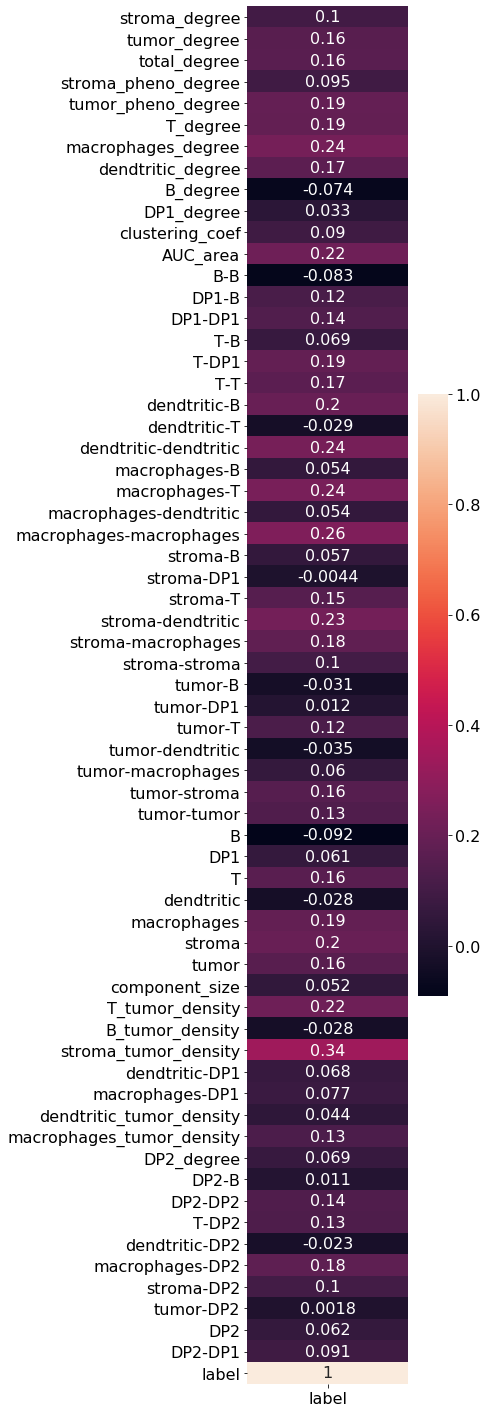

In [139]:
correlation_nodes = laplace_quadratics_features.corr('kendall')
f, ax = plt.subplots(figsize=(7, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,63:],annot=True)
if (INCLUDE_DR == False) and (N_CLASSES == 2):
    plt.tight_layout()

    plt.savefig(PLOT_DIRECTORY + 'laplace_correlation_label.png')
if (INCLUDE_DR == True) and (N_CLASSES == 2):
    plt.tight_layout()
    plt.savefig(PLOT_DIRECTORY + '2_classes_DR_laplace_correlation_label.png')



In [140]:
correlation_nodes = laplace_quadratics_features.corr()
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,:],annot=False)
plt.tight_layout()
plt.savefig(PLOT_DIRECTORY + 'laplace_correlation.png')
plt.close()

## Kendall tau

In [141]:
label = laplace_quadratics_features.label.values
laplace_columns_ = laplace_quadratics_features.columns[1:]
kendall_corr ={}
for column in laplace_columns_:
    if column != 'name' :
        column_value = laplace_quadratics_features[column].values
        kendall_corr[column] = scipy.stats.kendalltau(column_value, label).correlation

kendall_corr = pd.DataFrame(kendall_corr, index = [0])
kendall_corr = pd.melt(kendall_corr).set_index(['variable'])
f, ax = plt.subplots(figsize=(7, 20))
ax = sns.heatmap(kendall_corr,annot=True)
plt.tight_layout()
plt.savefig(PLOT_DIRECTORY + 'label_kendall_tau.png')
plt.close()

## Spearmann rho 

In [142]:
label = laplace_quadratics_features.label.values
nodes_columns_ = laplace_quadratics_features.columns[1:]
spearmanr_corr ={}


for column in nodes_columns_:
    if column != 'name' :
        column_value = laplace_quadratics_features[column].values
        spearmanr_corr[column] = scipy.stats.spearmanr(column_value, label).correlation

    
spearmanr_corr = pd.DataFrame(spearmanr_corr, index = [0])
spearmanr_corr = pd.melt(spearmanr_corr).set_index(['variable'])
f, ax = plt.subplots(figsize=(7, 20))
ax = sns.heatmap(spearmanr_corr,annot=True)
plt.tight_layout()
plt.savefig(PLOT_DIRECTORY + 'laplace_spearman_rho.png')
plt.close()

In [143]:
correlation_nodes = laplace_quadratics_features.corr()
f, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(correlation_nodes.iloc[:,:])
plt.savefig(PLOT_DIRECTORY + 'laplace_correlation.png')
plt.close()

# Principal component analysis

In [144]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
label = laplace_quadratics_features.label.values
features_scaled= laplace_quadratics_features.drop(['name','label'],axis=1)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf['label'] = label

In [145]:
sns.pairplot(principalDf, hue='label', corner =True).savefig(PLOT_DIRECTORY+'Laplace_PCA.png')
plt.close()

In [146]:
pca.explained_variance_ratio_

array([0.5903718 , 0.08842073, 0.04927532])

## Principal component per set of features

In [147]:
list_columns_sets = list(laplace_columns.keys())
principal_component_explained_df = pd.DataFrame({})

for column_set in list_columns_sets:
     
    columns_values = laplace_columns[column_set]
    n = len(columns_values)
    restricted_data = laplace_quadratics_features[columns_values]
    X = restricted_data.drop(['name','label'], axis=1)
    label = restricted_data.label.values
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
    principalDf['label'] = label
    explained_variance_ratio = pca.explained_variance_ratio_
    print(explained_variance_ratio)
    df = pd.DataFrame({'name':column_set,'pc1':explained_variance_ratio[0],'pc2':explained_variance_ratio[1],'pc3':explained_variance_ratio[2]}, index =[0])
    principal_component_explained_df = pd.concat([principal_component_explained_df,df])
    plt.tight_layout()

    sns.pairplot(principalDf, hue='label', corner =True)
    
    plt.savefig(PLOT_DIRECTORY+ column_set+'laplace_PCA.png')
    plt.close()
    

[0.63154517 0.08799916 0.06644859]
[0.72028222 0.10223873 0.0607174 ]
[0.72544221 0.15540615 0.04918391]
[0.46058949 0.19731648 0.1591512 ]
[0.90503774 0.0764931  0.01846916]


<Figure size 432x288 with 0 Axes>

In [148]:
print(principal_component_explained_df.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &              name &       pc1 &       pc2 &       pc3 \\
\midrule
0 &        edge\_count &  0.631545 &  0.087999 &  0.066449 \\
0 &            degree &  0.720282 &  0.102239 &  0.060717 \\
0 &        cell\_count &  0.725442 &  0.155406 &  0.049184 \\
0 &  tils\_tumor\_ratio &  0.460589 &  0.197316 &  0.159151 \\
0 &    graph\_topology &  0.905038 &  0.076493 &  0.018469 \\
\bottomrule
\end{tabular}



# Canonical correlation analysis

In [149]:
X = laplace_quadratics_features.iloc[:,3:].drop(['name','label'],axis=1)
Y = laplace_quadratics_features.label.values

In [150]:
Y

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

In [151]:
ca = CCA()
ca.fit(X, Y)
X_c, Y_c = ca.transform(X, Y)

print(X_c.shape)
print(Y_c.shape)

(63, 2)
(63,)


Y residual constant at iteration 1


In [152]:
np.corrcoef(X_c[:, 0], Y_c[:, ])

array([[ 1.       , -0.9916017],
       [-0.9916017,  1.       ]])

### Checking separability

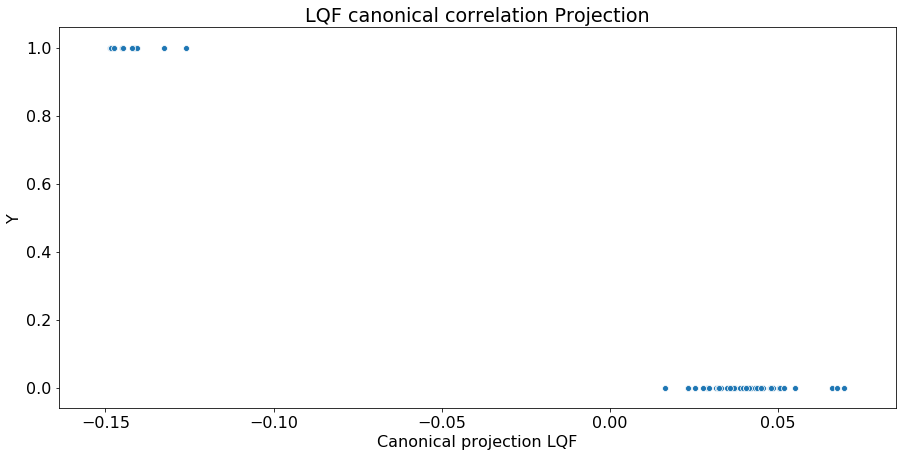

In [153]:
X_c_1 = [x[0] for x in X_c]
plt.figure(figsize=(15,7))
sns.scatterplot(X_c_1,Y)
plt.xlabel('Canonical projection LQF')
plt.ylabel('Y')
plt.title('LQF canonical correlation Projection')
plt.savefig(PLOT_DIRECTORY + 'canonical_correlation_laplace_all features.png')

### Fitting a 1D classifier

In [154]:
X_c_1 = np.array(X_c_1).reshape(-1,1)

In [155]:
clf = svm.SVC(kernel ='rbf' , class_weight='balanced')

clf.fit(X_c_1,Y)
y_pred = clf.predict(X_c_1)
confusion_matrix(Y,y_pred)

array([[49,  0],
       [ 0, 14]])

### Checking CCA independently using set of columns
#### Merging nodes_features to region cells densities

In [156]:
list_columns_sets = list(laplace_columns.keys())
canonical_correlation = []
training_accuracy = []

for column_set in list_columns_sets:
    
    columns_values = laplace_columns[column_set]
    n = len(columns_values)
    restricted_data = laplace_quadratics_features[columns_values]
    X = restricted_data.drop(['name','label'], axis=1)
    Y = restricted_data.label.values
    ca = CCA()
    ca.fit(X, Y)
    X_c, Y_c = ca.transform(X, Y)
    cca = np.corrcoef(X_c[:, 0], Y_c[:, ])[0,1]
    
    X_c_1 = np.array(X_c_1).reshape(-1,1)
    clf =  LogisticRegression(random_state=0,class_weight = {0:1,1:20})
    clf.fit(X_c_1,Y)
    
    
    training_accuracy.append(clf.score(X_c_1,Y))
    
    print(cca)
    canonical_correlation.append(cca)

-0.7100016648130524
0.39911206439480773
0.4248853370338362
0.49976341129079377
0.34922340665004115


Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1


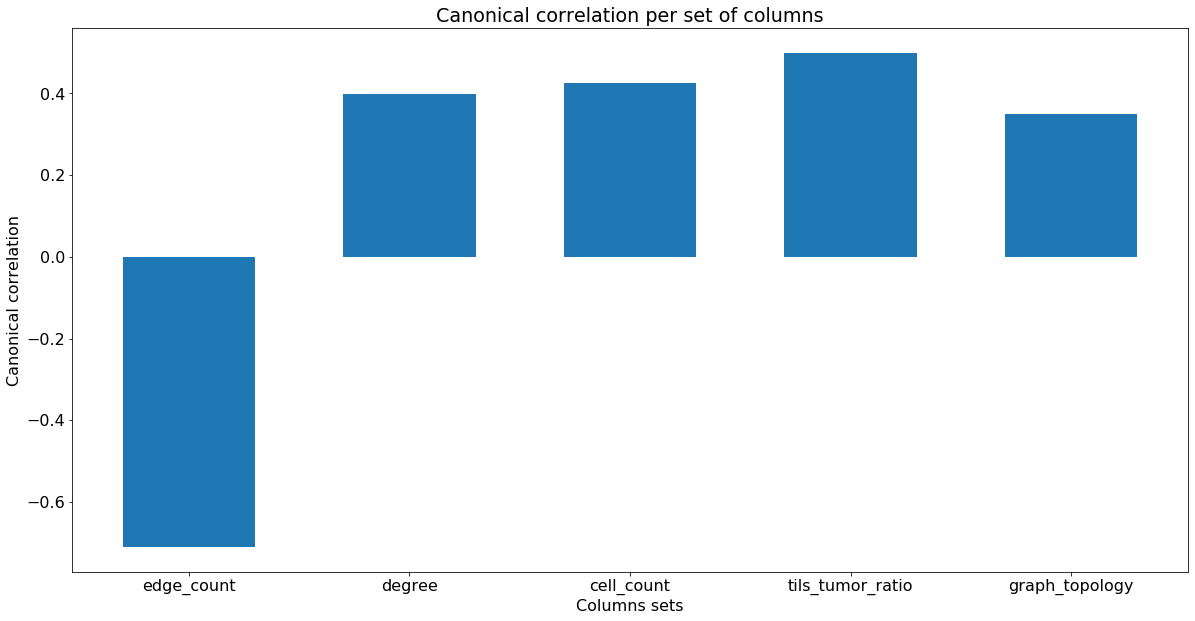

In [157]:
plt.figure(figsize=(20,10))

plt.bar(list_columns_sets, canonical_correlation, width = 0.6)
plt.xlabel('Columns sets')
plt.ylabel('Canonical correlation')
plt.title('Canonical correlation per set of columns')
plt.savefig(PLOT_DIRECTORY + 'Laplace quadtratic Canonical correlation per set of columns.png')

Text(0.5, 1.0, 'Canonical correlation per set of columns')

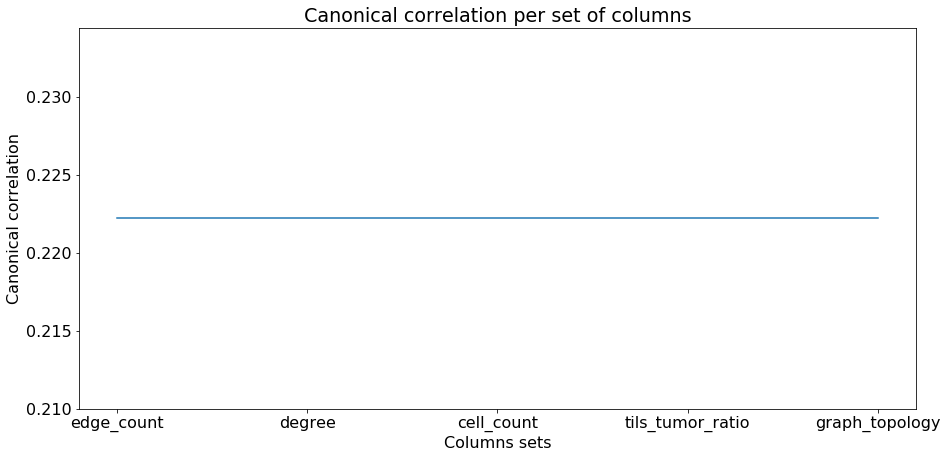

In [158]:
plt.figure(figsize=(15,7))

plt.plot(list_columns_sets, training_accuracy)
plt.xlabel('Columns sets')
plt.ylabel('Canonical correlation')
plt.title('Canonical correlation per set of columns')


# Fitting classifiers

## All data as training

In [159]:
X = laplace_quadratics_features.drop(['name','label'],axis=1)
y = laplace_quadratics_features.label.values

### SVM: POLY

In [160]:
if N_CLASSES == 2:
    clf = svm.SVC(kernel ='poly', degree =1,class_weight ='balanced')
if N_CLASSES == 3:
    clf = OneVsRestClassifier(svm.SVC(kernel ='poly', degree =1,class_weight ='balanced'))

clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[44,  5],
       [ 8,  6]])

### SVM: RBF

In [161]:
if N_CLASSES == 2:
    clf = svm.SVC(kernel ='rbf',class_weight ='balanced')
    
if N_CLASSES == 3:
    clf = OneVsRestClassifier(svm.SVC(kernel ='rbf',class_weight ='balanced'))

clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [ 5,  9]])

### Logistic regression

In [162]:
if N_CLASSES == 2:
    clf = LogisticRegression(random_state=0,class_weight ='balanced')

if N_CLASSES == 3:
    clf = OneVsRestClassifier(clf = LogisticRegression(random_state=0,class_weight ='balanced'))
    
clf.fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([[49,  0],
       [ 0, 14]])

###  Random forest

In [163]:
if N_CLASSES == 2:
    clf = RandomForestClassifier(max_depth=6, random_state=0,class_weight ='balanced')

if N_CLASSES == 3:
    clf = OneVsRestClassifier(clf = RandomForestClassifier(max_depth=6, random_state=0))
    
clf.fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [ 0, 14]])

## K- Folds cross validation

iteration: 0
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[[34  0]
 [ 0 10]]
Testing Error :
[1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[13  2]
 [ 1  3]]
iteration: 1
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[[34  0]
 [ 0 10]]
Testing Error :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[14  1]
 [ 4  0]]
iteration: 2
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


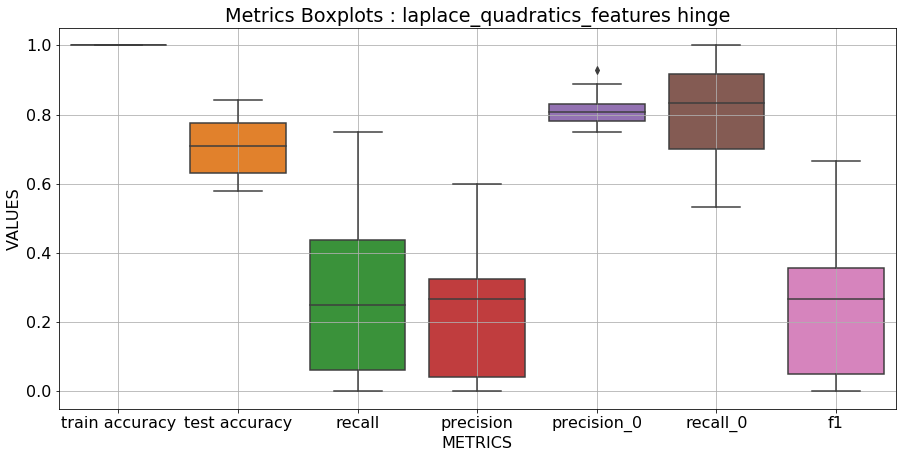

In [173]:
fit_model(laplace_quadratics_features,'laplace_quadratics_features',PLOT_DIRECTORY=PLOT_DIRECTORY,MODEL='hinge',N_FOLDS=10, N_CLASSES = 2,MINOR_CLASS_PENALTY =2,INCLUDE_DR=False, Boxplot=True)


## Feature importance

In [ ]:
model = RandomForestClassifier(max_depth=10, criterion= 'gini',random_state=0, class_weight={0:1,1:20} )
model.fit(X, y)
y_pred = model.predict(X)
confusion_matrix(y,y_pred)

In [ ]:
shap.initjs()
f, ax = plt.subplots(figsize=(15, 15))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns,show = False)
plt.tight_layout()
plt.savefig(PLOT_DIRECTORY + 'Feature importance: Laplace features.png')

# Class weight Penality

In [ ]:
df = laplace_quadratics_features
DATA = 'Laplace quadtratics'
model = 'hinge'
crieterion = 'entropy'
degree = 10
min_weight = 1
max_weight = 25
a,b,c = class_1_weight_inspection(df,model,crieterion,degree,min_weight,max_weight)

In [ ]:
plt.figure(figsize=(15,7))
weights = range(min_weight,max_weight)

plt.plot(weights,a, label = 'Training accuracy'  )
plt.plot(weights,b, label = 'Testing accuracy'  )
plt.plot(weights,c, label = 'recall accuracy'  )
plt.xlabel('Class one penalty weight')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
if model == 'polynomial':
    plt.title(' Class 1 weight optimisation : DATA : ' + DATA +' Model : '+ model + ' degree : '+ str(degree))
    plt.savefig(PLOT_DIRECTORY + 'class_one_weight_optimisation'+DATA+'_'+model + ' degree: '+ str(degree)+'.png')
    
elif model == 'forest':
    plt.title(' Class 1 weight optimisation : DATA : ' + DATA +' Model: '+ model + ' Criterion: '+ crieterion)
    plt.savefig(PLOT_DIRECTORY + 'class_one_weight_optimisation' + DATA+'_'+model + ' Crieterion: '+ crieterion+'.png') 
    
else  :
    plt.title('Class 1 weight optimisation : DATA :' + DATA +' Model: '+ model )
    plt.savefig(PLOT_DIRECTORY + 'class_one_weight_optimisation'+ DATA+'_'+model + '.png') 

# Clustering coefficient

In [ ]:
clus_coef_df = clus_coef_df.drop_duplicates(['name'])

In [ ]:
correlation_types = ['pearson','kendall','spearman']
correlation_type = correlation_types[0]
correlation_nodes = clus_coef_df.corr(correlation_type)
f, ax = plt.subplots(figsize=(7, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,27:],annot=True)
plt.tight_layout()
plt.savefig(PLOT_DIRECTORY + 'clustering_coefficients_'+correlation_type+'_correlation_label.png')


In [ ]:
pca = PCA(n_components=3)
label = clus_coef_df.label.values
features_scaled= clus_coef_df.drop(['name','label'],axis=1)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf['label'] = label

In [ ]:
sns.pairplot(principalDf, hue='label', corner =True).savefig(PLOT_DIRECTORY+'clustering_Coefficients_PCA.png')

In [ ]:
pca.explained_variance_ratio_

In [ ]:
fit_model(clus_coef_df,'clustering_coef',PLOT_DIRECTORY=PLOT_DIRECTORY,MODEL='forest',N_FOLDS=3, N_CLASSES = 2,MINOR_CLASS_PENALTY =30,INCLUDE_DR=False)


# Fitting classifiers

## All data as training

In [ ]:
X = clus_coef_df.drop(['name','label'],axis=1)
y = clus_coef_df.label.values

### SVM: POLY

In [ ]:
if N_CLASSES == 2:
    clf = svm.SVC(kernel ='poly', degree =1,class_weight ='balanced')
if N_CLASSES == 3:
    clf = OneVsRestClassifier(svm.SVC(kernel ='poly', degree =1,class_weight ='balanced'))

clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

### SVM: RBF

In [ ]:
if N_CLASSES == 2:
    clf = svm.SVC(kernel ='rbf',class_weight ='balanced')
    
if N_CLASSES == 3:
    clf = OneVsRestClassifier(svm.SVC(kernel ='rbf',class_weight ='balanced'))

clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

### Logistic regression

In [ ]:
if N_CLASSES == 2:
    clf = LogisticRegression(random_state=0,class_weight ='balanced')

if N_CLASSES == 3:
    clf = OneVsRestClassifier(clf = LogisticRegression(random_state=0,class_weight ='balanced'))
    
clf.fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

### Random forest

In [ ]:
if N_CLASSES == 2:
    clf = RandomForestClassifier(max_depth=6, random_state=0,class_weight ='balanced')

if N_CLASSES == 3:
    clf = OneVsRestClassifier(clf = RandomForestClassifier(max_depth=6, random_state=0))
    
clf.fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

In [ ]:
shap.initjs()
f, ax = plt.subplots(figsize=(15, 15))
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, show = False)
plt.tight_layout()
plt.savefig(PLOT_DIRECTORY + 'Feature importance : Clustering_coefs.png')

## Checking Class 1 weight penality

In [ ]:
df = clus_coef_df
DATA = 'clustering_coefficient'
model = 'forest'
crieterion = 'entropy'
degree = 10
min_weight = 1
max_weight = 25
a,b,c = class_1_weight_inspection(df,model,crieterion,degree,min_weight,max_weight)


In [ ]:
plt.figure(figsize=(15,7))
weights = range(min_weight,max_weight)

plt.plot(weights,a, label = 'Training accuracy'  )
plt.plot(weights,b, label = 'Testing accuracy'  )
plt.plot(weights,c, label = 'recall accuracy'  )
plt.xlabel('Class one penalty weight')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
if model == 'polynomial':
    plt.title(' Class 1 weight optimisation : DATA : ' + DATA +' Model : '+ model + ' degree : '+ str(degree))
    plt.savefig(PLOT_DIRECTORY + 'class_one_weight_optimisation'+DATA+'_'+model + ' degree: '+ str(degree)+'.png')
    
elif model == 'forest':
    plt.title(' Class 1 weight optimisation : DATA : ' + DATA +' Model: '+ model + ' Criterion: '+ crieterion)
    plt.savefig(PLOT_DIRECTORY + 'class_one_weight_optimisation' + DATA+'_'+model + ' Crieterion: '+ crieterion+'.png') 
    
else  :
    plt.title('Class 1 weight optimisation : DATA :' + DATA +' Model: '+ model )
    plt.savefig(PLOT_DIRECTORY + 'class_one_weight_optimisation'+ DATA+'_'+model + '.png') 

In [ ]:
len(region_nodes_counts)

# Region Phenotype densities

In [ ]:
correlation_types = ['pearson','kendall','spearman']
correlation_type = correlation_types[0]
correlation_nodes = region_nodes_counts.corr(correlation_type)
f, ax = plt.subplots(figsize=(7, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,26:],annot=True)
plt.tight_layout()

plt.savefig(PLOT_DIRECTORY + 'Region_phenotype_'+correlation_type+'_correlation_label.png')


In [ ]:
pca = PCA(n_components=3)
label = region_nodes_counts.label.values
features_scaled= region_nodes_counts.drop(['name','label'],axis=1)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf['label'] = label

In [ ]:
sns.pairplot(principalDf, hue='label', corner =True).savefig(PLOT_DIRECTORY+'Region_phenotype_densities_PCA.png')

# Fitting classifiers

## All data as training

In [ ]:
X = region_nodes_counts.drop(['name','label'],axis=1)
y = region_nodes_counts.label.values

### SVM: POLY

In [ ]:
if N_CLASSES == 2:
    clf = svm.SVC(kernel ='poly', degree =3,class_weight ='balanced')
if N_CLASSES == 3:
    clf = OneVsRestClassifier(svm.SVC(kernel ='poly', degree =1,class_weight ='balanced'))

clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

### SVM: RBF

In [ ]:
if N_CLASSES == 2:
    clf = svm.SVC(kernel ='rbf',class_weight ='balanced')
    
if N_CLASSES == 3:
    clf = OneVsRestClassifier(svm.SVC(kernel ='rbf',class_weight ='balanced'))

clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

### Logistic regression

In [ ]:
if N_CLASSES == 2:
    clf = LogisticRegression(random_state=0,class_weight ='balanced')

if N_CLASSES == 3:
    clf = OneVsRestClassifier(clf = LogisticRegression(random_state=0,class_weight ='balanced'))
    
clf.fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

### Random forest

In [ ]:
if N_CLASSES == 2:
    clf = RandomForestClassifier(max_depth=6, random_state=0,class_weight ='balanced')

if N_CLASSES == 3:
    clf = OneVsRestClassifier(clf = RandomForestClassifier(max_depth=6, random_state=0))
    
clf.fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

In [ ]:
shap.initjs()
f, ax = plt.subplots(figsize=(15, 15))
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns,show = False)
plt.tight_layout()
plt.savefig(PLOT_DIRECTORY + 'Feature importance : Region_phenotype_count.png')

## Checking Class 1 weight penality

In [ ]:
df = region_nodes_counts
DATA = 'region phenotype densities'
model = 'forest'
crieterion = 'gini'
degree = 10
min_weight = 1
max_weight = 25
a,b,c = class_1_weight_inspection(df,model,crieterion,degree,min_weight,max_weight)


In [ ]:
plt.figure(figsize=(15,7))
weights = range(min_weight,max_weight)

plt.plot(weights,a, label = 'Training accuracy'  )
plt.plot(weights,b, label = 'Testing accuracy'  )
plt.plot(weights,c, label = 'recall accuracy'  )
plt.xlabel('Class one penalty weight')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
if model == 'polynomial':
    plt.title(' Class 1 weight optimisation : DATA : ' + DATA +' Model : '+ model + ' degree : '+ str(degree))
    plt.savefig(PLOT_DIRECTORY + 'class_one_weight_optimisation'+DATA+'_'+model + ' degree: '+ str(degree)+'.png')
    
elif model == 'forest':
    plt.title(' Class 1 weight optimisation : DATA : ' + DATA +' Model: '+ model + ' Criterion: '+ crieterion)
    plt.savefig(PLOT_DIRECTORY + 'class_one_weight_optimisation' + DATA+'_'+model + ' Crieterion: '+ crieterion+'.png') 
    
else  :
    plt.title('Class 1 weight optimisation : DATA :' + DATA +' Model: '+ model )
    plt.savefig(PLOT_DIRECTORY + 'class_one_weight_optimisation'+ DATA+'_'+model + '.png') 